In [1]:
# !pip install --user scikit-surprise

In [2]:
from surprise import Reader, Dataset
import pandas as pd
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)

In [3]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
ratings_dict = {'itemID': list(df_blackfriday_data.Product_ID),
                'userID': list(df_blackfriday_data.User_ID),
                'rating': list((df_blackfriday_data.Purchase.pow(1/2)-3.464)/15)}
df = pd.DataFrame(ratings_dict)

# A reader is still needed but only the rating_scale param is required.
# The Reader class is used to parse a file containing ratings.
reader = Reader(rating_scale=(0, 10.0))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

In [5]:
from surprise import accuracy, Dataset, SVD, NMF, KNNBasic, CoClustering, SlopeOne, SVDpp, KNNWithMeans, KNNWithZScore, KNNBaseline
from surprise.model_selection import train_test_split, GridSearchCV


# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, random_state=random_seed, test_size=0.25)

# We'll use the famous SVD algorithm.
# algo = SVD()
# algo = KNNBaseline()
# algo = SlopeOne()
# for algo in [SVD(n_factors=18), SVD(n_factors=19), SVD(n_factors=20), SVD(n_factors=21), SVD(n_factors=22)]:
#     print('!!!!!!!!')
#     print(algo)
#     print()

#     # Train the algorithm on the trainset, and predict ratings for the testset
#     algo.fit(trainset)
#     predictions = algo.test(testset)

#     # Then compute RMSE
#     accuracy.rmse(predictions)

algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8776
0.8776345099684189


## Grid Search

In [6]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print(sqrt(mean_squared_error([(x.r_ui*15 +3.464)*(x.r_ui*15 +3.464) for x in predictions], [(x.est*15 +3.464)*(x.est*15 +3.464) for x in predictions])))


2506.1579574795296


In [7]:

df_test = pd.DataFrame({'User_ID':[x.uid for x in predictions], 
                        'Product_ID': [x.iid for x in predictions], 
                        'y_pred': [x.est*x.est*225 +3.464 for x in predictions],
                        'y': [x.r_ui*x.r_ui*225 +3.464 for x in predictions]})

df = pd.merge(df_test, df_blackfriday_data, on=['User_ID', 'Product_ID'], how='inner')

df

,User_ID,Product_ID,y_pred,y,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1004732,P00078542,8749.896136,4050.718928,M,26-35,14,B,2,1,1,2,16,4500
1,1000710,P00245642,4494.138753,6466.501853,M,26-35,20,A,4+,0,5,11,12,7032
2,1001284,P00156442,8230.248502,9203.937199,M,46-50,16,A,1,1,8,<NA>,<NA>,9877
3,1003028,P00247142,6379.598469,7405.416972,M,0-17,10,C,3,0,8,15,16,8010
4,1005677,P00220442,5417.973772,8028.824157,M,26-35,1,A,3,0,5,14,<NA>,8658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137512,1004512,P00100842,7148.003708,6435.825230,M,26-35,1,C,1,1,5,<NA>,<NA>,7000
137513,1001899,P00275742,7459.099795,7381.385341,F,46-50,6,A,1,1,8,16,<NA>,7985
137514,1003086,P00067942,6354.909659,8147.261268,M,18-25,12,A,1,1,5,14,<NA>,8781
137515,1001370,P00136542,5552.700502,3245.963924,M,36-45,2,C,2,1,5,8,<NA>,3649


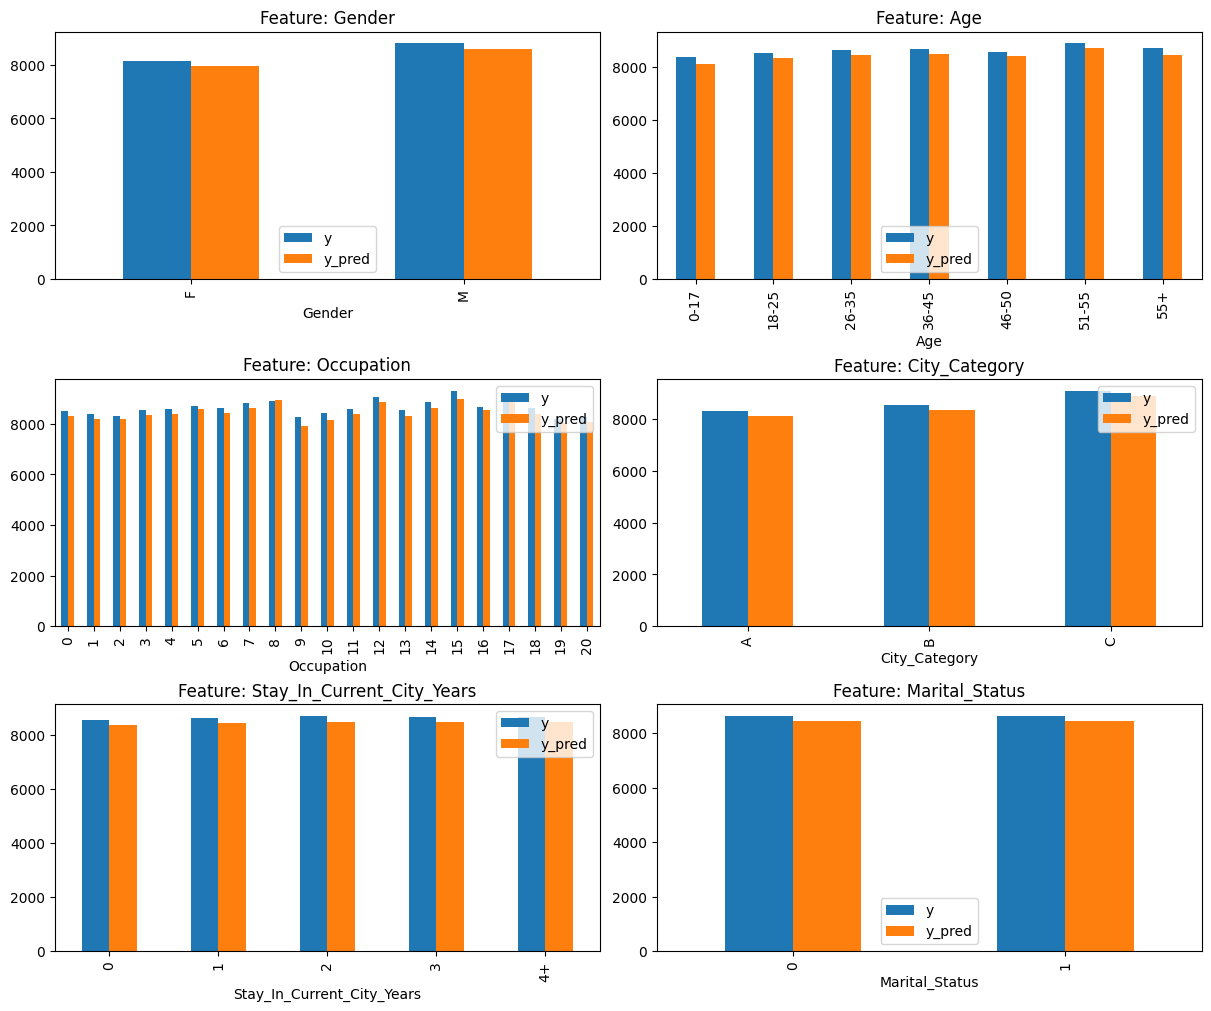

In [8]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,10), constrained_layout = True)


for i,f in enumerate(['Gender', 'Age', 'Occupation', 'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']):
    df.groupby(f)[['y','y_pred']].mean().plot(ax=axes[i//2, i%2] ,kind='bar', title=f'Feature: {f}')

<Axes: title={'center': 'Recommendation - SVD'}, xlabel='y', ylabel='y_pred'>

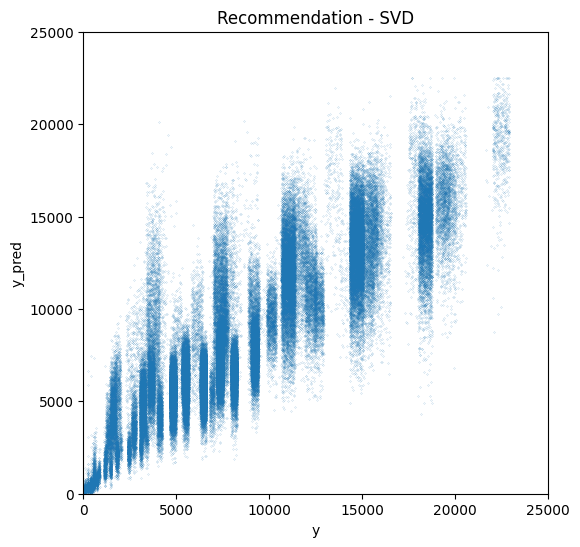

In [9]:
df[['y', 'y_pred']].plot.scatter(x='y', 
                                 y='y_pred', 
                                 xlim=[0,25000], 
                                 ylim=[0,25000], 
                                 s=0.01, 
                                 title='Recommendation - SVD',
                                 figsize=(6,6))